In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit
import torch
import tensorflow as tf
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

TensorFlow 2.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
path ="/content/drive/My Drive/19fallml/ProcessedData"
sampleX = torch.load(path+'/sample_train_X.pt')
# raw_sampleX = torch.load(path+'/sample_train_X.pt').numpy()
# sampleX = np.squeeze(raw_sampleX)
sampleY = np.loadtxt(path+'/sample_train_Y.txt').astype(np.int64)
sampleY = torch.from_numpy(sampleY)

print(sampleX.size())
print(sampleY.size())

torch.Size([2371, 3, 224, 224])
torch.Size([2371])


In [0]:
dataset = torch.utils.data.TensorDataset(sampleX, sampleY)

data_size = int(0.25 * len(dataset))  #只取1/4的数据作为dataset
dataset, _ = torch.utils.data.random_split(dataset, [data_size, len(dataset)-data_size])

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

dataset_sizes={
    "Train":train_size,
    "Test":test_size
}

class_names = ["Black grass","Charlock","Cleavers","Common Chickweed","Common wheat","Fat Hen","Loose Silky-bent","Maize","Scentless Mayweed","Shepherds Purse","Small-flowered Cranesbill","Sugar beet"]

# 把 dataset 放入 DataLoader
Train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,      # torch TensorDataset format
    batch_size=4,               # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=4,              # 多线程来读数据
)

Test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,      # torch TensorDataset format
    batch_size=4,               # mini batch size
    shuffle=False,               # 要不要打乱数据 (打乱比较好)
    num_workers=4,              # 多线程来读数据
)

dataloaders={
    "Train":Train_loader, #train dataset in train_loader
    "Test":Test_loader ##test dataset in test_loader
}



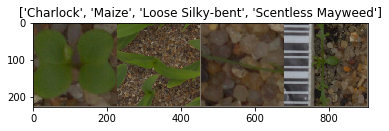

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(Train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
 
# training model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
#Fine tuning


model_ft = models.densenet121(pretrained=True)   #使用densenet121


num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 12)

# model_ft.load_state_dict(torch.load('params.pkl'))  #加载训练好的模型

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs, learning rate 每7个epoch缩小为0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [18]:


# Train and evaluate
model_ft= train_model(model_ft, criterion, optimizer_ft,exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
Train Loss: 1.9804 Acc: 0.3594
Test Loss: 0.9284 Acc: 0.7059

Epoch 1/24
----------
Train Loss: 0.9369 Acc: 0.7104
Test Loss: 0.5517 Acc: 0.8235

Epoch 2/24
----------
Train Loss: 0.5603 Acc: 0.8224
Test Loss: 0.6466 Acc: 0.8151

Epoch 3/24
----------
Train Loss: 0.4783 Acc: 0.8541
Test Loss: 0.6274 Acc: 0.8487

Epoch 4/24
----------
Train Loss: 0.3342 Acc: 0.8964
Test Loss: 0.5142 Acc: 0.8403

Epoch 5/24
----------
Train Loss: 0.2042 Acc: 0.9514
Test Loss: 0.4462 Acc: 0.8403

Epoch 6/24
----------
Train Loss: 0.1992 Acc: 0.9408
Test Loss: 0.5018 Acc: 0.8571

Epoch 7/24
----------
Train Loss: 0.1291 Acc: 0.9725
Test Loss: 0.4488 Acc: 0.8824

Epoch 8/24
----------
Train Loss: 0.1147 Acc: 0.9810
Test Loss: 0.4320 Acc: 0.8992

Epoch 9/24
----------
Train Loss: 0.1022 Acc: 0.9831
Test Loss: 0.4068 Acc: 0.8908

Epoch 10/24
----------
Train Loss: 0.1008 Acc: 0.9746
Test Loss: 0.3622 Acc: 0.8824

Epoch 11/24
----------
Train Loss: 0.0945 Acc: 0.9810
Test Loss: 0.3976 Acc